# Explore here

In [1]:
# importar modulos

#manejo de datos
import pandas as pd
import numpy as np
import datetime
# Graficación
import matplotlib.pyplot as plt
import seaborn as sns
# Analisis de la serie temporal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Modelo
from pmdarima import auto_arima
# Metricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
# Serializacion del modelo
import pickle



In [14]:
# Carga del dataframe
url = 'https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv'
pd.read_csv(url).to_csv('sales.csv', index=False)
df = pd.read_csv('sales.csv')
df.head(3)

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693


TRATAMIENTO DE LOS DATOS ORIGINALES|
--

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


Dos columnas:

- date que representa la fecha del dato y ventas que es el target a predecir

In [4]:
# Convertir la columna de fecha a tipo datetime
df['date'] = pd.to_datetime(df['date'])  
df.set_index('date', inplace=True)  # Establecer la columna de fecha como índice


---

ANALISIS DE LOS DATOS|
--

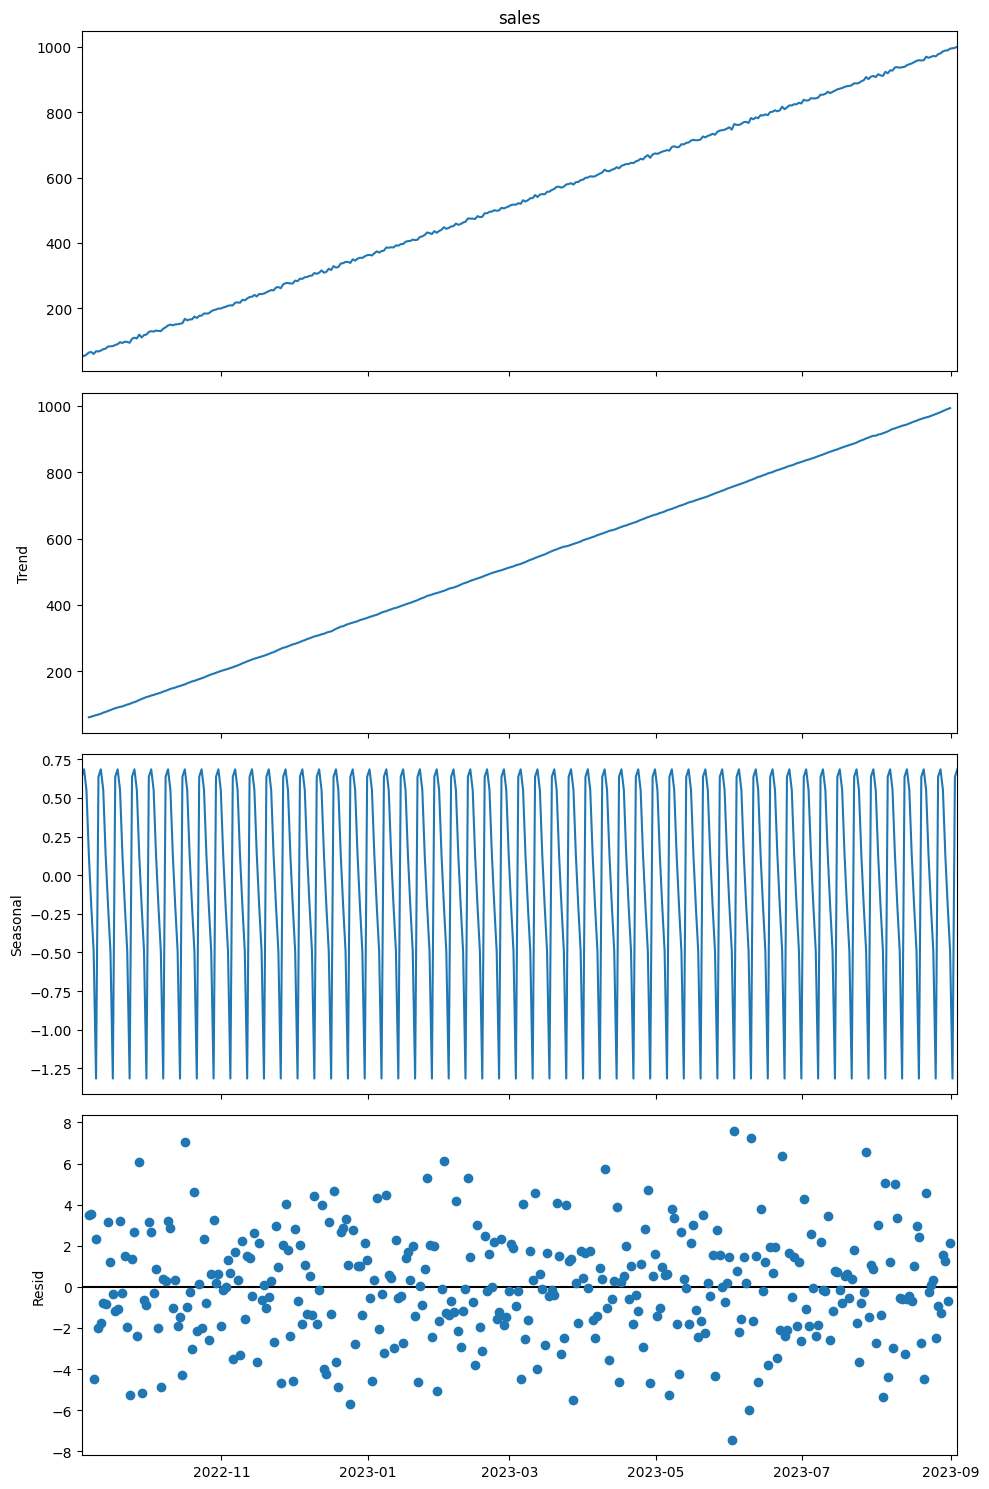

In [5]:
# Analizar la serie temporal graficamente

result = seasonal_decompose(df['sales'], model='additive')
# Dibujar los componentes
fig = result.plot()
# Configurar el tamaño del plot
fig.set_size_inches(10, 15)
# Ajuste del grafico
plt.tight_layout()
# Mostrar el gráfico
plt.show()

Conclusiones del analisis grafico:

- Se observan fuerte tendencia y estacionalidad en los datos

- La distribucion de los residuos esta en torno a cero y es aparentemente uniforme

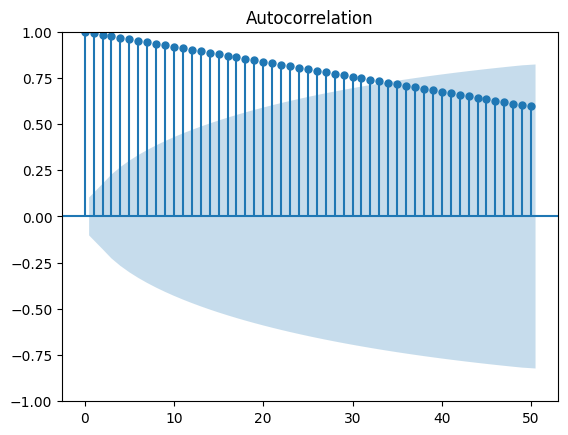

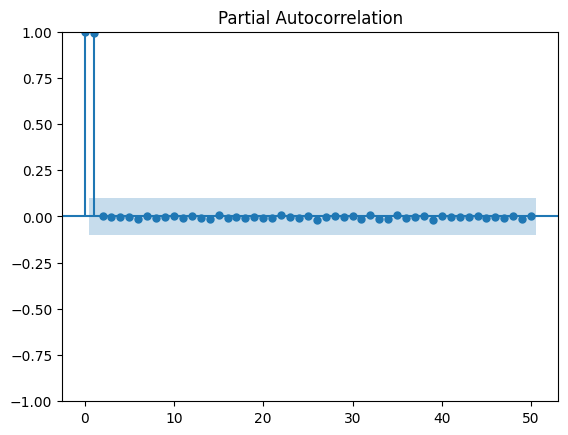

In [6]:
# Autocorrelacion y autocorrelacion parcial

plot_acf(df['sales'], lags=50)  

plot_pacf(df['sales'], lags=50) 

plt.show()


Conclusiones de los graficos de autocorrelacion

- Grafico de autocorrelacion bien definido , progresivo y sin cortes abruptos sugiere estacionariedad

- Grafico de autocorrelacion parcial con una fuerte cvaida abrupta en el lag 1, indica que un dato concreto esta muy determinado por el dato inmediatamente anterior

In [7]:
# Aplicar Dickey-Fuller

def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(df)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

Un resultado de 0.54 y p-value muy proximo a 1 indican que la hipotesis nula debe ser aceptada y se confirma la estacionariedad

---

Tratamiento de los datos|
--

In [8]:
# Diferenciacion para la eliminacion de estacionariedad
df_stationary = df.diff().dropna()
# Volvemos a aplicar el test de Dickey-Fuller
test_stationarity(df_stationary)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

Una vez apliocada una diferenciacion se comprueba de nuevo la estacionariedad ( valores del test y p-value niegan la hipotesis nula en esta ocasion y se confirma la no estacionariedad)

---

DIVISION DE DATOS EN CONJUNTOS DE ENTRENAMIENTO Y TEST|
--

In [9]:
# Definimos el tamaño del conjunto de entrenamiento con el 80% de los datos
train_size = int(len(df) * 0.8)
# Dividimos train y test 
train, test = df.iloc[:train_size], df.iloc[train_size:]
# Mostrar dimensiones
print("Train set size:", train.shape)
print("Test set size:", test.shape)


Train set size: (292, 1)
Test set size: (74, 1)


IMPLEMENTACION DEL MODELO ARIMA|
--

In [10]:
# Instancia del modelo autoarima que define automaticamente los mejores valores de parametros
model = auto_arima(train, seasonal = True, trace = True, m = 12)

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1483.238, Time=1.65 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1675.428, Time=0.13 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1579.885, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1477.110, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1763.761, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1475.165, Time=0.09 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1477.106, Time=0.38 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1478.875, Time=1.16 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1475.512, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=1475.495, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1578.564, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=1479.028, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=1762.924, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[12] intercept
Total fit time: 4.589 seconds


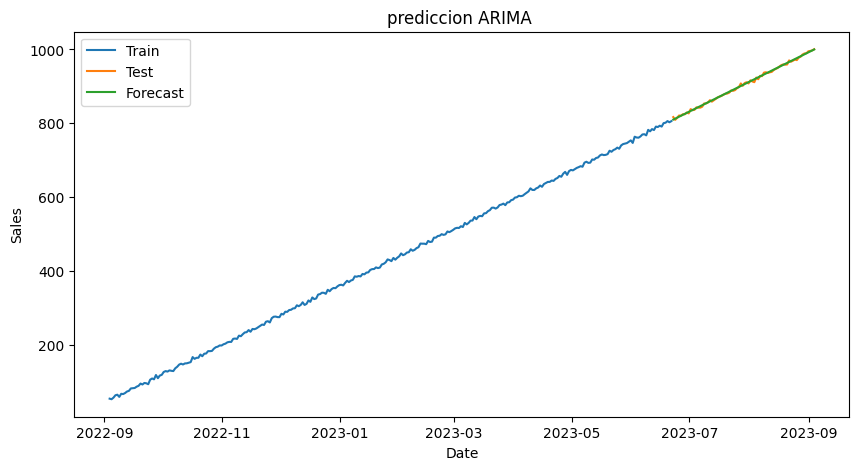

In [11]:
# Predicción sobre el conjunto de test
forecast = model.predict(n_periods=len(test))

# Graficar las predicciones contra los verdaderos valores
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(forecast, label='Forecast')
plt.title('prediccion ARIMA ')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


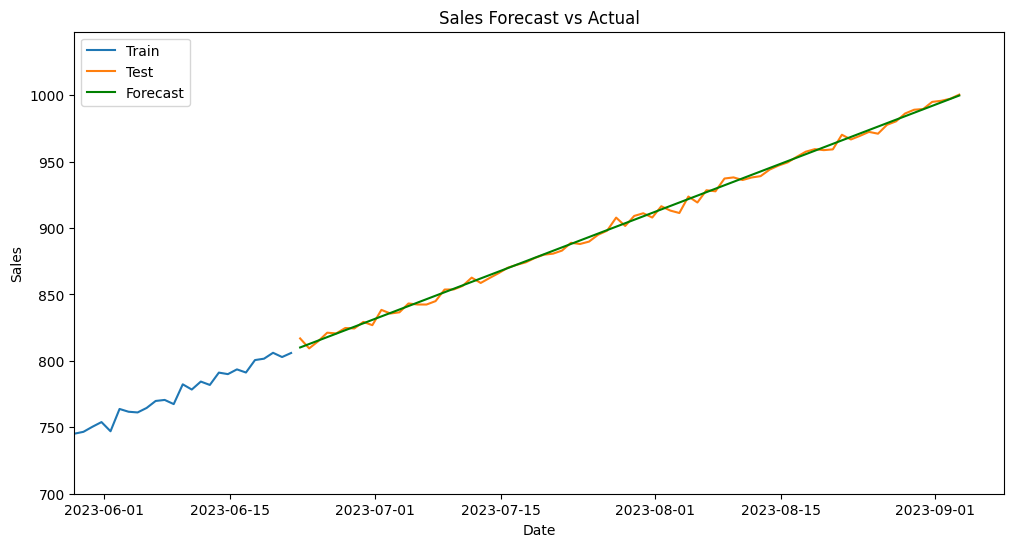

In [12]:
# Grafico de la prediccion ampliado

plt.figure(figsize=(12, 6))
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(forecast, label='Forecast', color='green')
# Define el iincio de los datos de test 
start_test_date = test.index.min()

# Ajusta el límite de la fecha de inicio para mostrar los últimos 10 días de entrenamiento
start_plot_date = start_test_date - pd.DateOffset(days=25)  
end_plot_date = test.index.max() + pd.DateOffset(days=5) 

# Establecer el limite inferior de {x} desde 25 dias antes de la fecha de inicio de test 
# Establecer el limite superior de {x} hasta 5 dias despues de la fecha de final del conjunto de test
plt.xlim([start_plot_date, end_plot_date])
# Establecer el limite inferior de {y} para aprovechar mejor el total del grafico
plt.ylim(700)
# Titulos y leyendas
plt.title('Sales Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Sales')
# Ubicacion de la leyenda a la izquierda del grafico
plt.legend(loc='upper left')
plt.show()


In [13]:
# Evaluacion del modelo

# Calculo de metricas sobre el conjunto de test
mse = mean_squared_error(test['sales'], forecast)
mae = mean_absolute_error(test['sales'], forecast)
mape = mean_absolute_percentage_error(test['sales'], forecast)

# Relacion de metricas obtenidas
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)

Mean Squared Error: 7.8249540613561
Mean Absolute Error: 2.232379203558273
Mean Absolute Percentage Error: 0.0024834469130511874


GUARDADO DEL MODELO|
--

In [21]:
pickle.dump(model , open('/workspaces/linea_temporal_alternativa/models/time_series_model.pkl' , 'wb'))

FINAL DE LA PRACTICA|
--
- Se ha profundizado en el preprocesado necesario para los datos de series temporales
- Se ha creado correctamente un modelo ARIMA entrenado con el 80% de los datos 
- Se han obtenido las metricas del modelo sobre el conjunto de test
- Se ha guardado el modelo final